In [12]:
import os
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from lenstools import ConvergenceMap
from astropy import units as u

In [13]:
from src.info_extractor import InfoExtractor
from src.patch_analyser import PatchAnalyser
from src.fullsky_analyser import FullSkyAnalyser
from analysis import KappaAnalyser
from src.patch_processor import PatchProcessor
from src.utils import load_config, filter_config, setup_logging

In [14]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
config = load_config(config_file)
setup_logging()
zs =2.0

In [15]:
patch_size = config["patch_size"]
nbin = config["nbin"]
bins = np.linspace(-4, 4, nbin+1, endpoint=True)
binwidth = bins[1] - bins[0]
nu = (bins[1:] + bins[:-1]) / 2

In [5]:
sample_patch_tiled_path = list((workdir / "data" / "patches"/ "tiled"/ f"zs{zs}").glob(f"*.npy"))[1]
sample_patch_bigbox_path = list((workdir / "data" / "patches"/ "bigbox"/ f"zs{zs}").glob(f"*.npy"))[1]

In [6]:
sample_patch_tiled = np.load(sample_patch_tiled_path)
sample_patch_bigbox = np.load(sample_patch_bigbox_path)

In [7]:
# exclude index 130, 132, 134
sample_patch_tiled = np.delete(sample_patch_tiled, [130, 132, 134], axis=0)
sample_patch_bigbox = np.delete(sample_patch_bigbox, [130, 132, 134], axis=0)

In [8]:
conv_map_tiled = ConvergenceMap(sample_patch_tiled[0], angle=patch_size * u.deg).smooth(2.0 * u.arcmin)
conv_map_bigbox = ConvergenceMap(sample_patch_bigbox[0], angle=patch_size * u.deg).smooth(2.0 * u.arcmin)

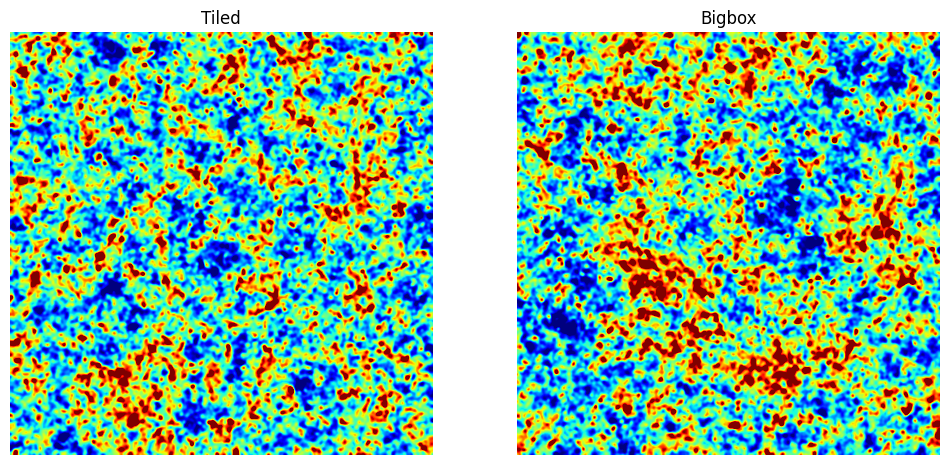

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(conv_map_tiled.data, cmap="jet", vmin=-0.032, vmax=0.032)
ax[0].set_title("Tiled")

ax[1].imshow(conv_map_bigbox.data, cmap="jet", vmin=-0.032, vmax=0.032)
ax[1].set_title("Bigbox")

for a in ax:
    a.axis("off")

plt.show()

In [17]:
def compute_peak_statistics(snr_map: ConvergenceMap, bins, binwidth, patch_size, is_minima=False):
    if is_minima:
        # Invert the map for minima computation
        snr_map = ConvergenceMap(-snr_map.data, angle=patch_size * u.deg)

    height, positions = snr_map.locatePeaks(bins)
    height, positions = exclude_edges(height, positions, snr_map.data.shape[0], patch_size)
    peaks = np.histogram(height, bins=bins)[0]
    peaks = peaks / np.sum(peaks) / binwidth
    return peaks

def exclude_edges(heights, positions, xsize, patch_size):
    """
    Excludes edge values from the peak or minima positions to avoid boundary issues.
    """
    # Scale positions to the patch size and apply boundary mask
    tmp_positions = positions.value * xsize / patch_size
    mask = (tmp_positions[:, 0] > 0) & (tmp_positions[:, 0] < xsize - 1) & \
            (tmp_positions[:, 1] > 0) & (tmp_positions[:, 1] < xsize - 1)
    return heights[mask], tmp_positions[mask].astype(int)

In [25]:
peaks_tiled = []
min_tiled = []
for patch in sample_patch_tiled:
    conv_map = ConvergenceMap(patch, angle=patch_size * u.deg)
    smoothed_map = conv_map.smooth(2.0*u.arcmin).data
    sigma0 = np.std(smoothed_map)
    smoothed_map = ConvergenceMap(smoothed_map/sigma0, angle=patch_size * u.deg)
    peaks = compute_peak_statistics(smoothed_map, bins, binwidth, patch_size)
    mins = compute_peak_statistics(smoothed_map, bins, binwidth, patch_size, is_minima=True)
    peaks_tiled.append(peaks)
    min_tiled.append(mins)
peaks_tiled = np.array(peaks_tiled)
min_tiled = np.array(min_tiled)

peaks_bigbox = []
min_bigbox = []
for patch in sample_patch_bigbox:
    conv_map = ConvergenceMap(patch, angle=patch_size * u.deg)
    smoothed_map = conv_map.smooth(2.0*u.arcmin).data
    sigma0 = np.std(smoothed_map)
    smoothed_map = ConvergenceMap(smoothed_map/sigma0, angle=patch_size * u.deg)
    peaks = compute_peak_statistics(smoothed_map, bins, binwidth, patch_size)
    mins = compute_peak_statistics(smoothed_map, bins, binwidth, patch_size, is_minima=True)
    peaks_bigbox.append(peaks)
    min_bigbox.append(mins)
peaks_bigbox = np.array(peaks_bigbox)
min_bigbox = np.array(min_bigbox)

In [26]:
def normalize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [27]:
peaks_tiled_norm = normalize(peaks_tiled)
min_tiled_norm = normalize(min_tiled)
peaks_bigbox_norm = normalize(peaks_bigbox)
min_bigbox_norm = normalize(min_bigbox)

/var/tmp/pbs.305964.idark/ipykernel_254084/2256306337.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (x - np.mean(x, axis=0)) / np.std(x, axis=0)


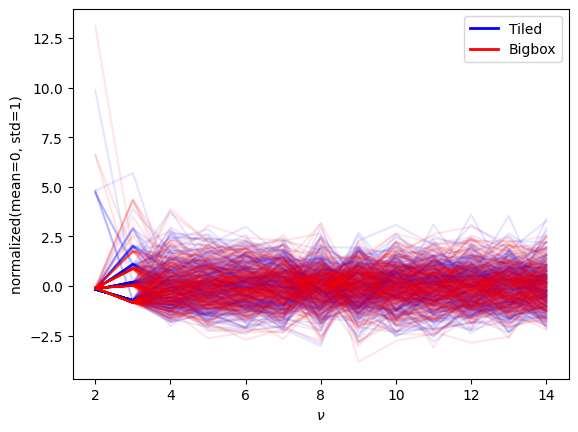

In [28]:
plt.plot(peaks_tiled_norm.T, color="blue", alpha=0.1)
plt.plot(peaks_bigbox_norm.T, color="red", alpha=0.1)

plt.legend([Line2D([0], [0], color="blue", lw=2), Line2D([0], [0], color="red", lw=2)], ["Tiled", "Bigbox"])

plt.xlabel(r"$\nu$")
plt.ylabel("normalized(mean=0, std=1)")
plt.show()

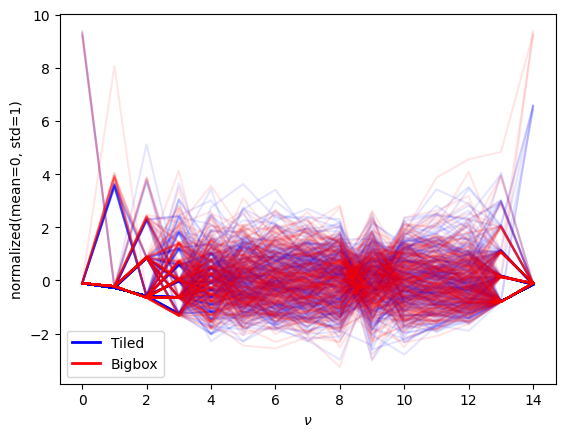

In [29]:
plt.plot(min_tiled_norm.T, color="blue", alpha=0.1)
plt.plot(min_bigbox_norm.T, color="red", alpha=0.1)

plt.legend([Line2D([0], [0], color="blue", lw=2), Line2D([0], [0], color="red", lw=2)], ["Tiled", "Bigbox"])

plt.xlabel(r"$\nu$")
plt.ylabel("normalized(mean=0, std=1)")
plt.show()

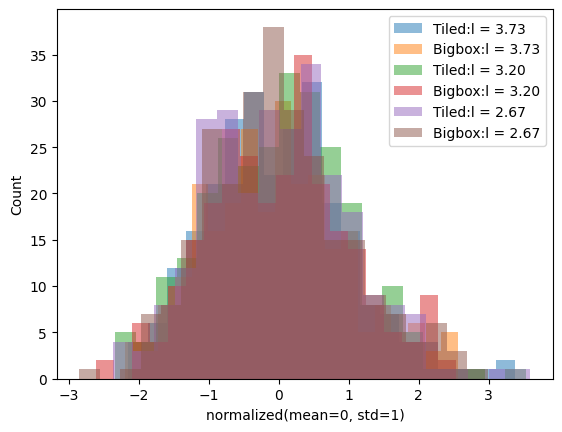

In [30]:
for i in range(1, 4):
    plt.hist(peaks_tiled_norm[:, -i], bins=20, alpha=0.5, label="Tiled:" + f"l = {nu[-i]:.2f}")
    plt.hist(peaks_bigbox_norm[:, -i], bins=20, alpha=0.5, label="Bigbox:" + f"l = {nu[-i]:.2f}")
plt.xlabel("normalized(mean=0, std=1)")
plt.ylabel("Count")
plt.legend()
plt.show()

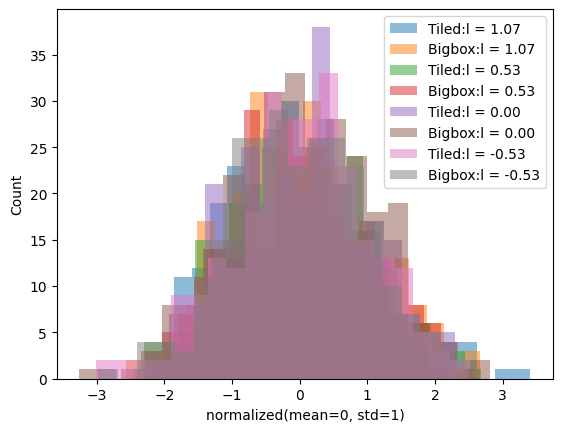

In [36]:
for i in range(6, 10):
    plt.hist(min_tiled_norm[:, i], bins=20, alpha=0.5, label="Tiled:" + f"l = {nu[-i]:.2f}")
    plt.hist(min_bigbox_norm[:, i], bins=20, alpha=0.5, label="Bigbox:" + f"l = {nu[-i]:.2f}")
plt.xlabel("normalized(mean=0, std=1)")
plt.ylabel("Count")
plt.legend()
plt.show()

/var/tmp/pbs.305964.idark/ipykernel_254084/3334212537.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(cov_peaks_bigbox/cov_peaks_tiled, cmap="bwr", vmin=0.5, vmax=1.5, origin="lower")


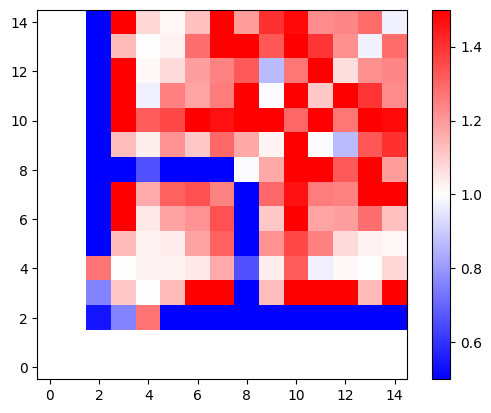

In [49]:
plt.imshow(cov_peaks_bigbox/cov_peaks_tiled, cmap="bwr", vmin=0.5, vmax=1.5, origin="lower")
plt.colorbar()
plt.show()

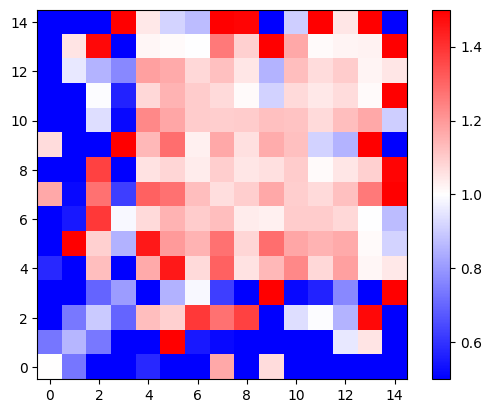

In [50]:
plt.imshow(cov_min_bigbox/cov_min_tiled, cmap="bwr", vmin=0.5, vmax=1.5, origin="lower")
plt.colorbar()
plt.show()

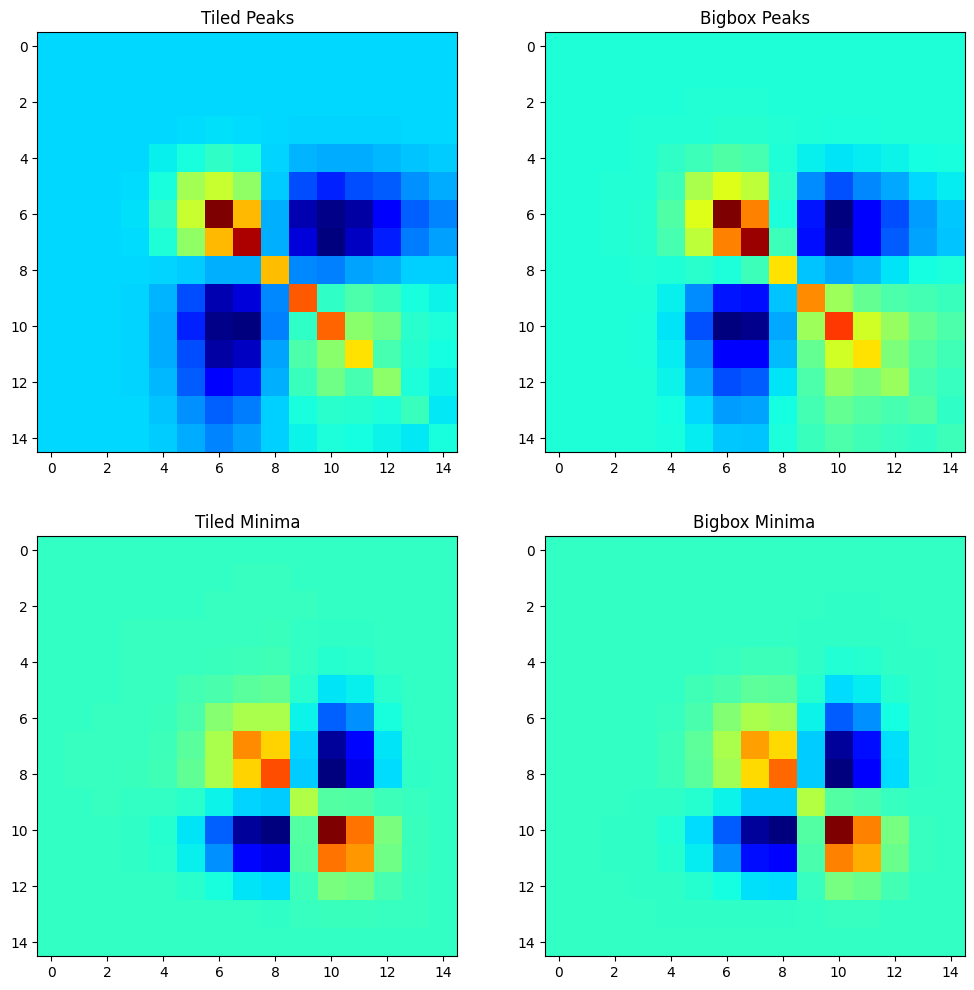

In [37]:
cov_peaks_tiled = np.cov(peaks_tiled.T)
cov_peaks_bigbox = np.cov(peaks_bigbox.T)
cov_min_tiled = np.cov(min_tiled.T)
cov_min_bigbox = np.cov(min_bigbox.T)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].imshow(cov_peaks_tiled, cmap="jet")
ax[0, 0].set_title("Tiled Peaks")
ax[0, 1].imshow(cov_peaks_bigbox, cmap="jet")
ax[0, 1].set_title("Bigbox Peaks")
ax[1, 0].imshow(cov_min_tiled, cmap="jet")
ax[1, 0].set_title("Tiled Minima")
ax[1, 1].imshow(cov_min_bigbox, cmap="jet")
ax[1, 1].set_title("Bigbox Minima")

plt.show()

/var/tmp/pbs.305964.idark/ipykernel_254084/3456309216.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.diag(cov_peaks_bigbox)/np.diag(cov_peaks_tiled))


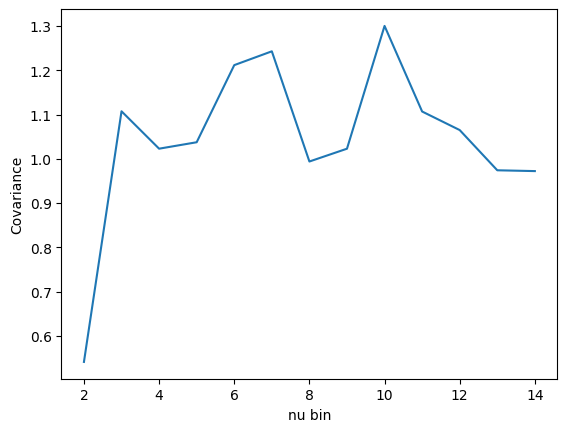

In [39]:
plt.plot(np.diag(cov_peaks_bigbox)/np.diag(cov_peaks_tiled))
plt.xlabel("nu bin")
plt.ylabel("Covariance")
plt.show()

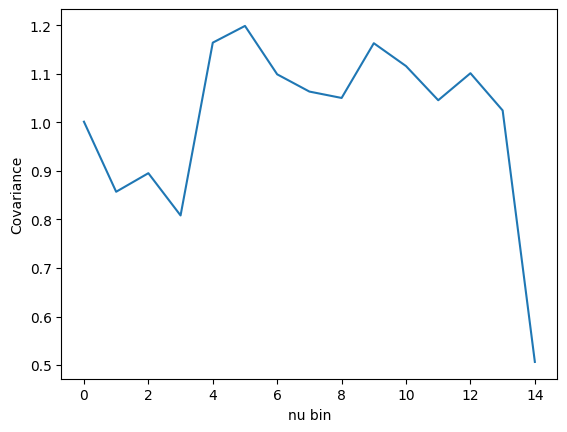

In [40]:
plt.plot(np.diag(cov_min_bigbox)/np.diag(cov_min_tiled), label="Tiled")
plt.xlabel("nu bin")
plt.ylabel("Covariance")
plt.show()